# Running LUNA

This notebook willdemonstrate how to run LUNA for an example dataset: MERFISH Mouse Primary Motor Cortex Atlas [1]. 

[1] Zhang, Meng, et al. "Spatially Resolved Cell Atlas of the Mouse Primary Motor Cortex by MERFISH." Nature 598.7879 (2021): 137-143.

## Prepare the dataset
### Download the data

First please [download data](https://drive.google.com/file/d/1YP1s_dERAUh7vXUjMRSvuFJllGBX8tYr/view?usp=drive_link) from the google drive, and uncompress the folder to extract the data for training and inference. 

In [1]:
# Make the csv
import pandas as pd
root_directory = '/mlbio_scratch/data/tiyu/mouse_cortex_merfish/mouse_cortex_merfish_data' # Change this to the directory where the data is stored
train_data = pd.read_csv(root_directory + '/merfish_mouse_cortex_train.csv', index_col=0)
test_data = pd.read_csv(root_directory + '/merfish_mouse_cortex_test.csv', index_col=0)

### Make sure the columns are standardised and aligned

1. the coordinates ('coord_X' and 'coord_Y'), cell section information ('cell_section'), and the cell annotation information ('cell_class') are included in the dataframe. For inference data that has no spatial information, please impute 'coord_X' and 'coord_Y' as zeros.

2. the order of genes for the train data and the test data should be aligned. 

In [2]:
required_columns = ['coord_X', 'coord_Y', 'cell_section', 'cell_class']

if not all(col in train_data.columns for col in required_columns):
    print('Please make sure that the columns coord_X, coord_Y, cell_section, and cell_class are in the train csv file')

if not all(col in test_data.columns for col in required_columns):
    print('Please make sure that the columns coord_X, coord_Y, cell_section, and cell_class are in the test csv file')

number_of_gene = 254

if not train_data.columns[:number_of_gene].equals(test_data.columns[:number_of_gene]):
    print('Please make sure that the order of the gene names is the same in the train and test csv files')


## Experiment Configuration

### Initialize configuration files

The experiment configuration is supported by hydra and omegaconf libraries. See details under the `configs/`. 

In [ ]:
import hydra
from omegaconf import DictConfig
from hydra import initialize, compose

# Initialize the Hydra config within Jupyter
initialize(config_path="../configs")  # Point to your config directory

# Compose the configuration
cfg = compose(config_name="config")   # Load your main config.yaml


In [4]:
cfg

{'validation': {'if_validate': False, 'batch_size': 8, 'save_model_every_n_epochs': 50, 'check_val_every_n_epochs': 100, 'check_val_monitor': 'val_loss/absolute_rssd', 'save_top_k_models': 40, 'early_stopping': True, 'early_stopping_patience': 100}, 'test': {'save_dir': './', 'checkpoints_parent_dir': None, 'checkpoints_name_list': 'all', 'batch_size': 1, 'epoch_index': None, 'checkpoint_path': None, 'test_save_parent_path': None}, 'general': {'name': 'MERFISH_mouse_cortex', 'wandb': 'online', 'mode': 'train_and_test', 'seed': 0, 'enable_progress_bar': True, 'local_saved_path': None}, 'train': {'n_epochs': 3000, 'batch_size': 6, 'lr': 0.0005, 'fast_dev_run': False, 'weight_decay': 1e-12}, 'model': {'n_layers': 8, 'diffusion_noise_schedule': 'cosine', 'diffusion_steps': 1000, 'nu': {'p': 2}, 'hidden_mlp_dims': {'X': 256, 'y': 256, 'pos': 64}, 'hidden_dims': {'dx': 256, 'dy': 1, 'num_heads': 16, 'dim_ffX': 256, 'dim_ffy': 256, 'dd': 64, 'output_features_to_pos_dims': 4}}, 'distribute': {

### Change configurations to run new experiment

In [5]:
## The following is the configuration file that you need to use for the experiment. Here is only for information. The command to run the experiment is in the next cell.

cfg.general.name = 'merfish_mouse_cortex' # Change this to the name of the experiment
cfg.dataset.gene_columns_start = 0
cfg.dataset.gene_columns_end = number_of_gene
cfg.dataset.train_data_path = root_directory + '/merfish_mouse_cortex_train.csv' # Change this to the path of the train csv file
cfg.dataset.test_data_path = root_directory + '/merfish_mouse_cortex_test.csv' # Change this to the path of the test csv file
cfg.test.save_dir = root_directory + '/merfish_mouse_cortex_test_results' # Change this to the directory where you want to save the results

### Run the model

For this experiment, we have 33 slices in total. If you have a 24GB GPU, e.g., RTX3090, you can run with batch size of 6. Change the batch size to fit to your GPU memory by changing `cfg.train.batch_size`

In [ ]:
!python3 ../main.py general.name=merfish_mouse_cortex \
                               dataset.gene_columns_start=0 \
                               dataset.gene_columns_end=254 \
                               dataset.train_data_path={root_directory}/merfish_mouse_cortex_train.csv \
                               dataset.test_data_path={root_directory}/merfish_mouse_cortex_test.csv \
                               test.save_dir={root_directory}/merfish_mouse_cortex_test_results


## Results visualization

The checkpoints will be saved under `../output/{date_of_the_experiment}/{time-stamp}-{cfg.general.name}/checkpoints` directory. 

If you set the `cfg.general.mode=train_and_test` (default), then the inference will automatically happen after the training for all the saved checkpoints. The evaluation results will be saved under your `cfg.train.save_dir` in the structure of `/{cfg.train.save_dir}/{time-stamp}-{cfg.general.name}_{checkpoints}/{cell_section_name}/` with the following files:

1. `metadata_pred.csv`: location generation results for cells from this section with three columns: coord_X, coord_Y and cell_class

2. `metadata_true.csv`: ground truth spatial information for cells from this section with three columns: coord_X, coord_Y and cell_class

3. `class_scatter_plot.pdf`: scatter plot that visualizes the inference results comparing the ground truth cell locations and predicted cell locations. Cells are color-coded by their `cell class`. 


In [7]:
## One example folder with the results for one slice (mouse2_slice300) is available at /example/example_result

metadata_true = pd.read_csv('./example_result/metadata_true.csv', index_col=0)
metadata_pred = pd.read_csv('./example_result/metadata_pred.csv', index_col=0)

In [8]:
metadata_pred.head()

,cell_class,coord_X,coord_Y
133277,Oligo,0.031256,0.245871
91841,Astro,0.134600,0.272333
55540,L6 CT,0.013424,0.191339
55257,L5 IT,0.070217,-0.006089
103231,L5 ET,-0.078457,0.070104


In [9]:
## To visualize the results, you can call the following function:
import colorcet as cc
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def plot_scatter_visualization(metadata_true, metadata_pred, uniques):
    fig, axarr = plt.subplots(1, 2, figsize=(16, 6))

    # Define the color palette for the unique categories
    pl_palette = sns.color_palette(cc.glasbey, n_colors=len(uniques))
    palette_dict = dict(zip(uniques, pl_palette))

    # Groundtruth Plot
    axarr[0].set_title("Ground truth", fontsize=16)  # Adjust title font size
    g1 = sns.scatterplot(
        data=metadata_true,
        x="coord_X",
        y="coord_Y",
        hue="cell_class",
        s=15,
        ax=axarr[0],
        palette=palette_dict,
        legend=False,  # Do not automatically create a legend
    )
    g1.set_xlabel("X", fontsize=14)  # Adjust X-axis label font size
    g1.set_ylabel("Y", fontsize=14)  # Adjust Y-axis label font size

    # Prediction Plot
    axarr[1].set_title("Prediction", fontsize=16)  # Adjust title font size
    g2 = sns.scatterplot(
        data=metadata_pred,
        x="coord_X",
        y="coord_Y",
        hue="cell_class",
        s=15,
        ax=axarr[1],
        palette=palette_dict,
        legend=False,  # Do not automatically create a legend
    )
    g2.set_xlabel("X", fontsize=14)  # Adjust X-axis label font size
    g2.set_ylabel("Y", fontsize=14)  # Adjust Y-axis label font size

    # Create custom legend
    legend_elements = [
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label=cat,
            markerfacecolor=palette_dict[cat],
            markersize=10,
        )
        for cat in uniques
    ]
    ncol = len(uniques) // 4  # Number of columns in the legend
    fig.legend(
        handles=legend_elements,
        loc="upper center",
        ncol=ncol,
        bbox_to_anchor=(0.5, -0.05),
    )

    plt.tight_layout()
    plt.show()

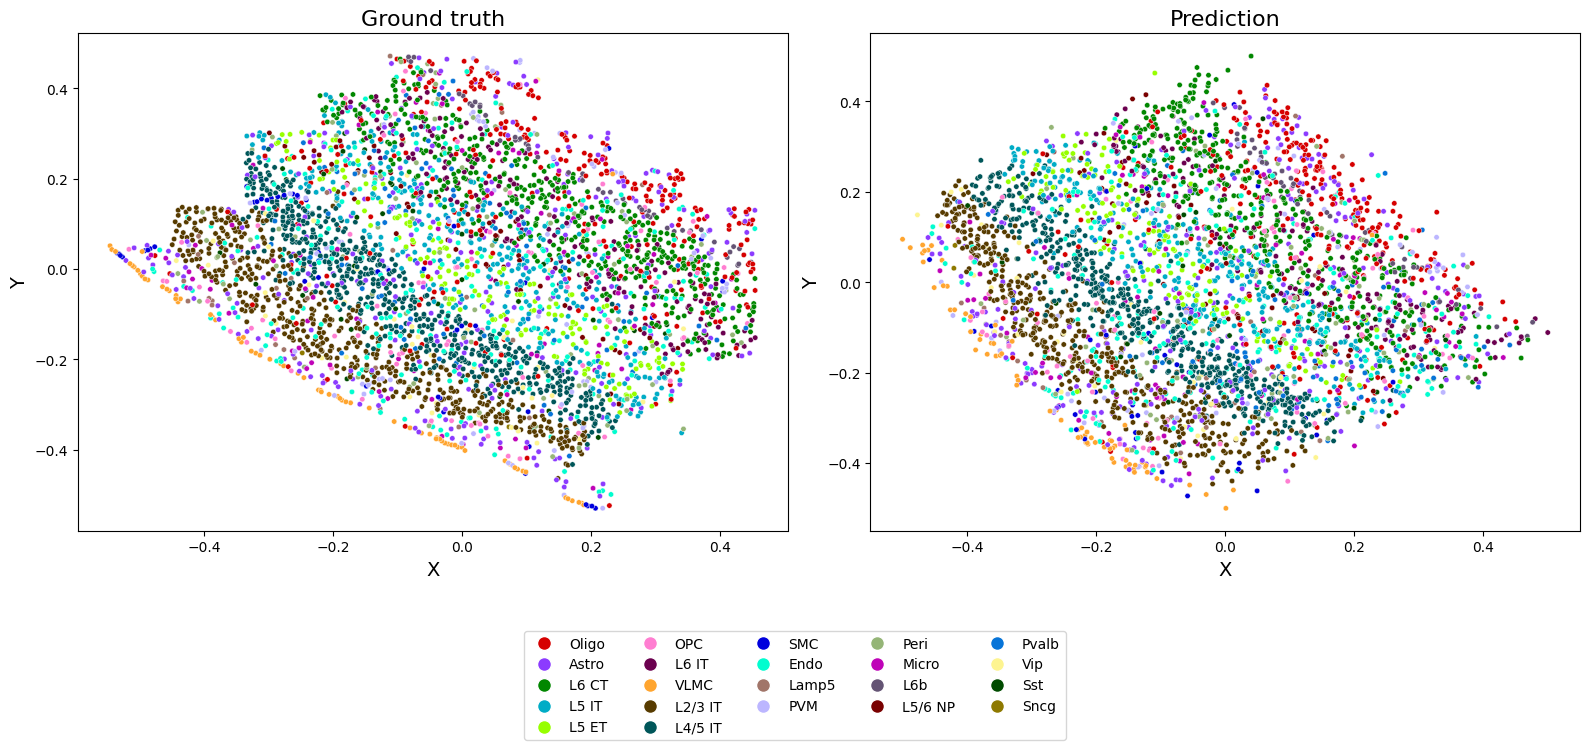

In [10]:
plot_scatter_visualization(metadata_true, metadata_pred, metadata_true['cell_class'].unique())